In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix

In [2]:
analysis_df = pd.read_csv("./Data/check_fraud.csv", low_memory=False)

In [3]:
analysis_df.shape

(307664, 615)

In [42]:
#pull out approved volume to fit and validate the models on
approve_vol = analysis_df[(analysis_df['RC4_AUTH_IND'] == 'A') & ((analysis_df['DUP_PRES_IND'] == 1) | (analysis_df['LOSS_IND'] == -1))]
approve_vol.drop(columns = 'RC4_AUTH_IND', inplace = True)
approve_vol.groupby(['DUP_PRES_IND','LOSS_IND']).count()

,,TXN_UID,FACE_AMOUNT,NAT_POSITIVE_GRADE,SEGMENT,char_CHECK_NO,ID_STATION_STATE,LOCAL_HOUR,DAY_OF_WEEK,AGE,MOD_FACE_AMT,...,C_R_AV_APP_D_12M_14D_RT,C_R_AV_APP_D_6M_7D_RT,C_R_DLY_APPR_24M_14D_RT,C_R_DLY_APPR_12M_14D_RT,C_R_DLY_APPR_6M_3M_RT,C_STD_C_AVG_TIME_24M_RT,C_STD_C_AVG_TIME_6M_RT,C_STD_C_AVG_TIME_30D_RT,C_STD_C_AVG_TIME_18D_RT,C_STD_C_AVG_TIME_14D_RT
DUP_PRES_IND,LOSS_IND,,,,,,,,,,,,,,,,,,,,,
-1,-1,250000,250000,164837,250000,250000,250000,250000,250000,247134,250000,...,217937,206962,231899,217937,155036,219757,183641,115755,69038,55431
1,1,2615,2615,701,2615,2615,2615,2615,2615,2571,2615,...,1839,1582,2149,1839,1034,1880,1173,506,320,250


In [44]:
#pull out target var, need to convert the -1's to 0's for the neural net
y_train = approve_vol[approve_vol['SEGMENT'] == 'DEV'].DUP_PRES_IND
y_val = approve_vol[approve_vol['SEGMENT'] == 'VDT'].DUP_PRES_IND

y_train_bin = y_train.replace(-1, 0)
y_val_bin = y_val.replace(-1, 0)

X_train = approve_vol[approve_vol['SEGMENT'] == 'DEV'].drop(columns = ['TXN_UID','SEGMENT','DUP_PRES_IND','LOSS_IND'])
X_val = approve_vol[approve_vol['SEGMENT'] == 'VDT'].drop(columns = ['TXN_UID','SEGMENT','DUP_PRES_IND','LOSS_IND'])

#I also need a data frame of all transactions, including declines, that I can score for deeper analysis
X_deep_dive = analysis_df.drop(columns = ['TXN_UID','SEGMENT','DUP_PRES_IND','LOSS_IND','RC4_AUTH_IND'])

In [55]:
print("Train Target: {} , Val Target: {}".format(y_train_bin.sum(),y_val_bin.sum()))

Train Target: 1178 , Val Target: 1437


In [56]:
#need to replace missing values, different logic for numeric vs categoricals
# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]
numerical_cols

['FACE_AMOUNT',
 'LOCAL_HOUR',
 'AGE',
 'MOD_FACE_AMT',
 'FA_ROUND',
 'M_DAYS_FIRST_DECL_L1',
 'M_ATT_CNT_60D_L1',
 'M_ATT_CNT_90D_L1',
 'M_ATT_DLR_3D_L1',
 'M_ATT_DLR_30D_L1',
 'M_ATT_DLR_60D_L1',
 'M_ATT_DLR_90D_L1',
 'M_APPR_CNT_7D_L1',
 'M_APPR_CNT_30D_L1',
 'M_APPR_DLR_60D_L1',
 'M_DECL_CNT_3D_L1',
 'M_DECL_CNT_7D_L1',
 'M_DECL_CNT_90D_L1',
 'M_DECL_DLR_30D_L1',
 'M_DECL_DLR_60D_L1',
 'M_UNIT_GLR_60D_L1',
 'M_UNIT_GLR_30D_L1',
 'M_DLR_GLR_60D_L1',
 'M_APPR_DLR_90D_L3',
 'M_APPR_CNT_60D_L3',
 'M_APPR_DLR_60D_L3',
 'M_APPR_CNT_60D_L7',
 'M_APP_CKNO_SFA_X_90D_L1',
 'M_DECL_RATE_90D_L1',
 'M_FA_DFAV_APPR_90D_L1',
 'M_FA_DFMX_APPR_90D_L1',
 'M_APPR_FA_SFA_60D_L1',
 'M_APPR_CKNO_SFA_60D_L1',
 'M_FA_DFAV_APPR_60D_L1',
 'M_APP_CKNO_SFA_X_30D_L1',
 'M_FA_DFAV_APPR_30D_L1',
 'M_FA_PDFAV_APPR_30D_L1',
 'M_APPR_FA_SFA_7D_L1',
 'M_APP_CKNO_SFA_X_7D_L1',
 'M_FA_PDFMX_APPR_7D_L1',
 'M_APPR_FA_SFA_3D_L1',
 'M_DECL_DLR_RATE_3D_L1',
 'M_FA_DFAV_APPR_3D_L1',
 'M_FA_PDFAV_APPR_3D_L1',
 'M_FA_PDFMX_AP

In [57]:
# Impute numeric columns, simple fill with -999 value
my_numeric_imputer = SimpleImputer(strategy='constant', fill_value=-999)
num_X_train = X_train[numerical_cols]
num_X_val = X_val[numerical_cols]
num_X_deep_dive = X_deep_dive[numerical_cols]

imputed_num_X_train = pd.DataFrame(my_numeric_imputer.fit_transform(num_X_train))
imputed_num_X_val = pd.DataFrame(my_numeric_imputer.transform(num_X_val))
imputed_num_X_deep_dive = pd.DataFrame(my_numeric_imputer.transform(num_X_deep_dive))

# Imputation removed column names; put them back
imputed_num_X_train.columns = num_X_train.columns
imputed_num_X_val.columns = num_X_val.columns
imputed_num_X_deep_dive.columns = num_X_deep_dive.columns

imputed_num_X_train.head()

,FACE_AMOUNT,LOCAL_HOUR,AGE,MOD_FACE_AMT,FA_ROUND,M_DAYS_FIRST_DECL_L1,M_ATT_CNT_60D_L1,M_ATT_CNT_90D_L1,M_ATT_DLR_3D_L1,M_ATT_DLR_30D_L1,...,C_R_AV_APP_D_12M_14D_RT,C_R_AV_APP_D_6M_7D_RT,C_R_DLY_APPR_24M_14D_RT,C_R_DLY_APPR_12M_14D_RT,C_R_DLY_APPR_6M_3M_RT,C_STD_C_AVG_TIME_24M_RT,C_STD_C_AVG_TIME_6M_RT,C_STD_C_AVG_TIME_30D_RT,C_STD_C_AVG_TIME_18D_RT,C_STD_C_AVG_TIME_14D_RT
0,353.46,7.0,20.0,53.0,0.0,-999.0,6.0,12.0,0.0,494.44,...,0.773816,0.000000,3.409524,1.671429,0.857143,1.197902,1.044647,-11.425616,-999.000000,-999.000000
1,666.44,7.0,45.0,66.0,0.0,81.0,21.0,31.0,0.0,3980.25,...,0.897903,0.000000,2.045714,1.319549,0.857143,-2.133350,-1.849258,-1.862653,-999.000000,-999.000000
2,418.91,7.0,61.0,19.0,0.0,-999.0,12.0,19.0,0.0,2048.91,...,1.040836,1.046245,1.420635,1.166113,0.785714,-3.392236,-3.746517,-43.276650,-478.360659,-478.360659
3,636.81,7.0,43.0,37.0,0.0,-999.0,5.0,7.0,0.0,995.30,...,0.000000,-999.000000,0.000000,0.000000,-999.000000,-2.001617,-999.000000,-999.000000,-999.000000,-999.000000
4,768.07,7.0,41.0,68.0,0.0,77.0,57.0,91.0,0.0,14108.02,...,1.613987,1.448185,4.649351,7.163265,-999.000000,-1.472374,-0.623174,2.810837,2.345354,2.345354


In [58]:
#inspect categorical columns prior imputation
categorical_cols = [cname for cname in X_train.columns if
                    X_train[cname].nunique() < 21 and 
                    X_train[cname].dtype == "object"]
categorical_cols

['NAT_POSITIVE_GRADE', 'ID_STATION_STATE', 'DAY_OF_WEEK', 'ASIGN']

In [59]:
#Impute character values
my_categorical_imputer = SimpleImputer(strategy='constant', fill_value='Z')
char_X_train = X_train[categorical_cols]
char_X_val = X_val[categorical_cols]
char_X_deep_dive = X_deep_dive[categorical_cols]

imputed_char_X_train = pd.DataFrame(my_categorical_imputer.fit_transform(char_X_train))
imputed_char_X_val = pd.DataFrame(my_categorical_imputer.transform(char_X_val))
imputed_char_X_deep_dive = pd.DataFrame(my_categorical_imputer.transform(char_X_deep_dive))


# Imputation removed column names; put them back
imputed_char_X_train.columns = char_X_train.columns
imputed_char_X_val.columns = char_X_val.columns
imputed_char_X_deep_dive.columns = char_X_deep_dive.columns

imputed_char_X_train.head(10)

,NAT_POSITIVE_GRADE,ID_STATION_STATE,DAY_OF_WEEK,ASIGN
0,H,MATCH,FRI,VIRGO
1,C,MATCH,FRI,CAPRICORN
2,C,MATCH,FRI,ARIES
3,Z,MATCH,FRI,PISCES
4,H,MATCH,FRI,AQUARIUS
5,C,MATCH,FRI,SCORPIO
6,M,MATCH,FRI,SAGITTARIUS
7,H,MATCH,FRI,CANCER
8,C,MATCH,FRI,CANCER
9,Z,MIS-MATCH,FRI,SCORPIO


In [60]:
#I need to purge the columns that take on only one value
single_val_cat_cols = [cname for cname in imputed_char_X_train.columns if
                    imputed_char_X_train[cname].nunique() < 2]
single_val_cat_cols

[]

In [61]:
#now I need to convert the categorical columms to binary indicators with one-hot encoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_imputed_char_X_train = pd.DataFrame(OH_encoder.fit_transform(imputed_char_X_train))
OH_cols_imputed_char_X_val = pd.DataFrame(OH_encoder.transform(imputed_char_X_val))
OH_cols_imputed_char_X_deep_dive = pd.DataFrame(OH_encoder.transform(imputed_char_X_deep_dive))

# One-hot encoding removed index; put it back
OH_cols_imputed_char_X_train.index = imputed_char_X_train.index
OH_cols_imputed_char_X_val.index = imputed_char_X_val.index
OH_cols_imputed_char_X_deep_dive.index = imputed_char_X_deep_dive.index

#and need to bring in the column names 
OH_cols_imputed_char_X_train.columns = OH_encoder.get_feature_names(list(imputed_char_X_train.columns))
OH_cols_imputed_char_X_val.columns = OH_encoder.get_feature_names(list(imputed_char_X_val.columns))
OH_cols_imputed_char_X_deep_dive.columns = OH_encoder.get_feature_names(list(imputed_char_X_deep_dive.columns))

OH_cols_imputed_char_X_train

,NAT_POSITIVE_GRADE_C,NAT_POSITIVE_GRADE_F,NAT_POSITIVE_GRADE_H,NAT_POSITIVE_GRADE_M,NAT_POSITIVE_GRADE_Q,NAT_POSITIVE_GRADE_T,NAT_POSITIVE_GRADE_W,NAT_POSITIVE_GRADE_Z,NAT_POSITIVE_GRADE_\,NAT_POSITIVE_GRADE_^,...,ASIGN_CAPRICORN,ASIGN_GEMINI,ASIGN_LEO,ASIGN_LIBRA,ASIGN_PISCES,ASIGN_SAGITTARIUS,ASIGN_SCORPIO,ASIGN_TAURUS,ASIGN_VIRGO,ASIGN_Z
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125401,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
125402,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
125403,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#normalize the numeric features -- maybe later



In [62]:
#now merge the categorical and numeric columns back together
imputed_X_train = pd.concat([imputed_num_X_train, OH_cols_imputed_char_X_train], axis=1)
imputed_X_val = pd.concat([imputed_num_X_val, OH_cols_imputed_char_X_val], axis=1)
imputed_X_deep_dive = pd.concat([imputed_num_X_deep_dive, OH_cols_imputed_char_X_deep_dive], axis=1)

imputed_X_deep_dive.head()

,FACE_AMOUNT,LOCAL_HOUR,AGE,MOD_FACE_AMT,FA_ROUND,M_DAYS_FIRST_DECL_L1,M_ATT_CNT_60D_L1,M_ATT_CNT_90D_L1,M_ATT_DLR_3D_L1,M_ATT_DLR_30D_L1,...,ASIGN_CAPRICORN,ASIGN_GEMINI,ASIGN_LEO,ASIGN_LIBRA,ASIGN_PISCES,ASIGN_SAGITTARIUS,ASIGN_SCORPIO,ASIGN_TAURUS,ASIGN_VIRGO,ASIGN_Z
0,353.46,7.0,20.0,53.0,0.0,-999.0,6.0,12.0,0.0,494.44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,666.44,7.0,45.0,66.0,0.0,81.0,21.0,31.0,0.0,3980.25,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,418.91,7.0,61.0,19.0,0.0,-999.0,12.0,19.0,0.0,2048.91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,636.81,7.0,43.0,37.0,0.0,-999.0,5.0,7.0,0.0,995.30,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,768.07,7.0,41.0,68.0,0.0,77.0,57.0,91.0,0.0,14108.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
#now create a list of the features going into the model
pred_attr = list(imputed_X_train.columns)
pred_attr

['FACE_AMOUNT',
 'LOCAL_HOUR',
 'AGE',
 'MOD_FACE_AMT',
 'FA_ROUND',
 'M_DAYS_FIRST_DECL_L1',
 'M_ATT_CNT_60D_L1',
 'M_ATT_CNT_90D_L1',
 'M_ATT_DLR_3D_L1',
 'M_ATT_DLR_30D_L1',
 'M_ATT_DLR_60D_L1',
 'M_ATT_DLR_90D_L1',
 'M_APPR_CNT_7D_L1',
 'M_APPR_CNT_30D_L1',
 'M_APPR_DLR_60D_L1',
 'M_DECL_CNT_3D_L1',
 'M_DECL_CNT_7D_L1',
 'M_DECL_CNT_90D_L1',
 'M_DECL_DLR_30D_L1',
 'M_DECL_DLR_60D_L1',
 'M_UNIT_GLR_60D_L1',
 'M_UNIT_GLR_30D_L1',
 'M_DLR_GLR_60D_L1',
 'M_APPR_DLR_90D_L3',
 'M_APPR_CNT_60D_L3',
 'M_APPR_DLR_60D_L3',
 'M_APPR_CNT_60D_L7',
 'M_APP_CKNO_SFA_X_90D_L1',
 'M_DECL_RATE_90D_L1',
 'M_FA_DFAV_APPR_90D_L1',
 'M_FA_DFMX_APPR_90D_L1',
 'M_APPR_FA_SFA_60D_L1',
 'M_APPR_CKNO_SFA_60D_L1',
 'M_FA_DFAV_APPR_60D_L1',
 'M_APP_CKNO_SFA_X_30D_L1',
 'M_FA_DFAV_APPR_30D_L1',
 'M_FA_PDFAV_APPR_30D_L1',
 'M_APPR_FA_SFA_7D_L1',
 'M_APP_CKNO_SFA_X_7D_L1',
 'M_FA_PDFMX_APPR_7D_L1',
 'M_APPR_FA_SFA_3D_L1',
 'M_DECL_DLR_RATE_3D_L1',
 'M_FA_DFAV_APPR_3D_L1',
 'M_FA_PDFAV_APPR_3D_L1',
 'M_FA_PDFMX_AP

In [64]:
#converting labels to arrays before calling 
imputed_X_train = np.asarray(imputed_X_train)
y_train_bin = np.asarray(y_train_bin)
imputed_X_val = np.asarray(imputed_X_val)
y_val_bin = np.asarray(y_val_bin)

imputed_X_deep_dive = np.asarray(imputed_X_deep_dive)

#need number of features for the model definition
input_shape = [imputed_X_train.shape[1]]

In [65]:
sample_count = [imputed_X_train.shape[0]]
sample_count

[125405]

In [93]:
neuron_count = sample_count[0]/(5*(input_shape[0] + 1))
neuron_count

39.250391236306726

In [233]:
#defining the model
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(15, activation='relu'),
#    layers.BatchNormalization(),
#    layers.Dropout(rate=0.3),
#    layers.Dense(40, activation='relu'),
    layers.BatchNormalization(),
#    layers.Dropout(rate=0.3),
    layers.Dense(1, activation='sigmoid')
])

#compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [234]:
#show time
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True
)
history = model.fit(
    imputed_X_train, y_train_bin,
    validation_data=(imputed_X_val, y_val_bin),
    batch_size=10000,
    epochs=200,
    callbacks=[early_stopping]
)

Train on 125405 samples, validate on 127210 samples
Epoch 1/200
125405/125405 [==============================] - 2s 19us/sample - loss: 0.7299 - binary_accuracy: 0.5239 - val_loss: 5.4232 - val_binary_accuracy: 0.9887
Epoch 2/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.6641 - binary_accuracy: 0.6157 - val_loss: 4.9706 - val_binary_accuracy: 0.9887
Epoch 3/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.6282 - binary_accuracy: 0.7810 - val_loss: 4.4715 - val_binary_accuracy: 0.9887
Epoch 4/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.5962 - binary_accuracy: 0.9060 - val_loss: 4.0331 - val_binary_accuracy: 0.9887
Epoch 5/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.5637 - binary_accuracy: 0.9542 - val_loss: 3.6566 - val_binary_accuracy: 0.9887
Epoch 6/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.5297 - binary_accuracy: 0.9772 -

Epoch 50/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.0516 - binary_accuracy: 0.9906 - val_loss: 0.1793 - val_binary_accuracy: 0.9886
Epoch 51/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.0512 - binary_accuracy: 0.9906 - val_loss: 0.1674 - val_binary_accuracy: 0.9886
Epoch 52/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.0507 - binary_accuracy: 0.9906 - val_loss: 0.1524 - val_binary_accuracy: 0.9887
Epoch 53/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.0502 - binary_accuracy: 0.9906 - val_loss: 0.1443 - val_binary_accuracy: 0.9887
Epoch 54/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.0499 - binary_accuracy: 0.9906 - val_loss: 0.1355 - val_binary_accuracy: 0.9887
Epoch 55/200
125405/125405 [==============================] - 2s 13us/sample - loss: 0.0495 - binary_accuracy: 0.9906 - val_loss: 0.1262 - val_binary_accuracy: 0.988

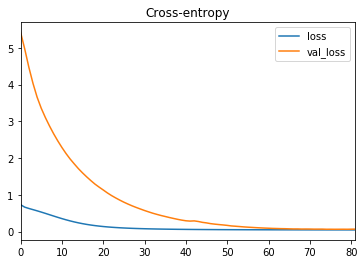

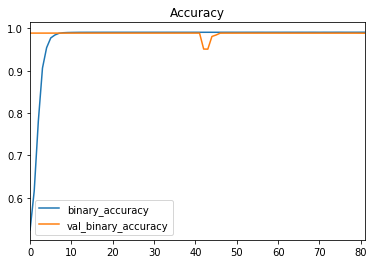

In [235]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

nn_pred = pd.DataFrame(model.predict_proba(imputed_X_val), columns = ['NEURAL_NET_PROB'])

In [214]:
#let see how this looks on a KS plot
eval_df = pd.merge(nn_pred, pd.DataFrame(y_val_bin, columns=['FRAUD_IND']), how='inner', left_index=True, right_index=True)

def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 50, duplicates="drop")
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(0,50)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 6)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "Bottom Decile Capture:" + str(kstable['cum_eventrate'][0]))
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

my_ks_df = ks(data=eval_df,target="FRAUD_IND", prob="NEURAL_NET_PROB")

        min_prob  max_prob  events  ...  cum_eventrate cum_noneventrate    KS
Decile                              ...                                      
0       0.051511  1.000000     120  ...          8.35%            1.93%   6.4
1       0.039882  0.051499      95  ...         14.96%            3.88%  11.1
2       0.033683  0.039879      86  ...         20.95%            5.83%  15.1
3       0.029551  0.033683     104  ...         28.18%            7.77%  20.4
4       0.026525  0.029550      70  ...         33.05%            9.74%  23.3
5       0.024064  0.026523      60  ...         37.23%           11.71%  25.5
6       0.021947  0.024063      61  ...         41.48%           13.69%  27.8
7       0.020166  0.021944      58  ...         45.51%           15.66%  29.8
8       0.018658  0.020165      55  ...         49.34%           17.64%  31.7
9       0.017250  0.018658      51  ...         52.89%           19.62%  33.3
10      0.015957  0.017250      51  ...         56.44%          

In [236]:
#create data frame with txn_uid and score to export out for comparison with my SAS work 
probs_deep_dive = pd.DataFrame(model.predict_proba(imputed_X_deep_dive), columns = ['NEURAL_NET_PROB'])
score_log_df = pd.merge(analysis_df['TXN_UID'], probs_deep_dive, how='inner', left_index=True, right_index=True)
score_log_df

,TXN_UID,NEURAL_NET_PROB
0,2705210000296,0.003269
1,2705210000299,0.004627
2,2705210000358,0.003669
3,2705210000366,0.008779
4,2705210000398,0.004647
...,...,...
307659,9006430014999,0.090475
307660,9006430015015,0.058014
307661,9006430015040,0.011123
307662,9006430015112,0.019441


In [217]:
#export scores so that I can compare to the logistic regression model I completed in SAS
score_log_df.to_csv("./Output/dup pres scores from neural net.csv", index = False)

In [245]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.wrappers.scikit_learn import KerasClassifier

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [224]:
#take a look into feature importance
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(imputed_X_train,y_train_bin)
eli5.show_weights(perm, feature_names = imputed_X_train.columns.tolist())

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001BF995417C8> does not.